# 1.Check Installation
CUDA driver, GPU, etc.

In [ ]:
# Check CUDA installation
print("---Writing the content of directories inluding CUDA---\n")
!ls /usr/local/
print("\n---Checking the NVCC directory--\n")
!which nvcc
print("\n---Call SMI for full detail---\n")
!nvidia-smi

# Correct CUDA directories
print("\n---Removing default CUDA directory--\n")
!rm -rf /usr/local/cuda
print("\n---Creating a symbolic link for CUDA-12--\n")
!ln -s /usr/local/cuda-12.2 /usr/local/cuda

---Writing the content of directories inluding CUDA---

bin    cuda	cuda-12.2  games	       include	lib64	   man	 share
colab  cuda-12	etc	   _gcs_config_ops.so  lib	licensing  sbin  src

---Checking the NVCC directory--

/usr/local/cuda/bin/nvcc

---Call SMI for full detail---

Tue May 28 09:53:03 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04

In [ ]:
# Test CUDA install
%%writefile hello.cu
#include<stdio.h>
__global__ void hello(void){
  printf("GPU: Hello!\n");
}

int main(int argc,char **argv){
  printf("CPU: Hello!\n");
  hello<<<1,10>>>();
  cudaDeviceReset();
  return 0;
}

Writing hello.cu


In [ ]:
# Compile the code
!nvcc hello.cu -o hello
# Run the code
!./hello

CPU: Hello!
GPU: Hello!
GPU: Hello!
GPU: Hello!
GPU: Hello!
GPU: Hello!
GPU: Hello!
GPU: Hello!
GPU: Hello!
GPU: Hello!
GPU: Hello!


# 2.Hello World

We are going to fill a vector of size N with a given value


In [ ]:
%%writefile fill1.cu

#include <stdio.h>
#include <stdlib.h>
#include "cuda.h"

// Device function to fill the vector
__global__ void fillKernel(int N, int val, int *c_a){

  // find index of thread relative to thread-block
  int t = threadIdx.x;

  // find index of thread-block relative to grid of thread-blocks
  int b = blockIdx.x;

  // find number of threads in thread-block
  int B = blockDim.x;

  // map from thread and thread-block indices into linear array index
  int n = t + b*B;

  // check index is in range
  if(n<N)
    // c_a[n] = val; // work done by a thread
    c_a[n] = n; // work done by thread

}

int main(int argc, char **argv){
  // 1. allocate HOST array
  int N = 12;
  int *h_a = (int*) calloc(N, sizeof(int));

  // 2. allocate DEVICE array
  int *c_a;
  cudaMalloc(&c_a, N*sizeof(int));

  // 3. launch DEVICE fill kernel
  int T = 256; // number of threads per thread block
  dim3 G( (N+T-1)/T ); // number of thread blocks to use
  dim3 B(T);

  int val = 999; // value to fill DEVICE array with
  fillKernel <<< G,B >>> (N, val, c_a);

  // 4. copy data from DEVICE array to HOST array
  cudaMemcpy(h_a, c_a, N*sizeof(int), cudaMemcpyDeviceToHost);

  // 5. print out values on HOST
  for(int n=0;n<N;++n) printf("h_a[%d] = %d\n", n, h_a[n]);

  // 6. free arrays
  cudaFree(c_a);
  free(h_a);
  return 0;
}

Writing fill1.cu


In [ ]:
!nvcc fill1.cu -o fill1
!./fill1

h_a[0] = 0
h_a[1] = 1
h_a[2] = 2
h_a[3] = 3
h_a[4] = 4
h_a[5] = 5
h_a[6] = 6
h_a[7] = 7
h_a[8] = 8
h_a[9] = 9
h_a[10] = 10
h_a[11] = 11


In [ ]:
%%writefile fill2.cu

#include <stdio.h>
#include <stdlib.h>
#include "cuda.h"

__global__ void fillKernel(int N, int val, int *c_a){

  // find index of thread relative to thread-block
  int t = threadIdx.x;

  // find index of thread-block relative to grid of thread-blocks
  int b = blockIdx.x;

  // find number of threads in thread-block
  int B = blockDim.x;

  // map from thread and thread-block indices into linear array index
  int n = t + b*B;

  // check index is in range
  if(n<N)
    // c_a[n] = val; // work done by thread
    c_a[n] = n; // work done by thread

}

// Main function
int main(int argc, char **argv){

  int N = 1024;

  // 1. allocate managed HOST/DEVICE array
  int *u_a;
  cudaMallocManaged(&u_a, N*sizeof(int));

  // 2. launch DEVICE fill kernel
  int T = 256; // number of threads per thread block
  dim3 G( (N+T-1)/T ); // number of thread blocks to use
  dim3 B(T);

  int val = 999; // value to fill DEVICE array with
  fillKernel <<< G,B >>> (N, val, u_a);

  // 3. synchronize with GPU (block until fillKernel finishes)
  cudaDeviceSynchronize();

  // 4. print out values on HOST
  for(int n=0;n<N;++n) printf("u_a[%d] = %d\n", n, u_a[n]);

  // 5. free arrays
  cudaFree(u_a);

  return 0;
}

Writing fill2.cu


In [ ]:
!nvcc fill2.cu -o fill2
!./fill2

u_a[0] = 0
u_a[1] = 1
u_a[2] = 2
u_a[3] = 3
u_a[4] = 4
u_a[5] = 5
u_a[6] = 6
u_a[7] = 7
u_a[8] = 8
u_a[9] = 9
u_a[10] = 10
u_a[11] = 11
u_a[12] = 12
u_a[13] = 13
u_a[14] = 14
u_a[15] = 15
u_a[16] = 16
u_a[17] = 17
u_a[18] = 18
u_a[19] = 19
u_a[20] = 20
u_a[21] = 21
u_a[22] = 22
u_a[23] = 23
u_a[24] = 24
u_a[25] = 25
u_a[26] = 26
u_a[27] = 27
u_a[28] = 28
u_a[29] = 29
u_a[30] = 30
u_a[31] = 31
u_a[32] = 32
u_a[33] = 33
u_a[34] = 34
u_a[35] = 35
u_a[36] = 36
u_a[37] = 37
u_a[38] = 38
u_a[39] = 39
u_a[40] = 40
u_a[41] = 41
u_a[42] = 42
u_a[43] = 43
u_a[44] = 44
u_a[45] = 45
u_a[46] = 46
u_a[47] = 47
u_a[48] = 48
u_a[49] = 49
u_a[50] = 50
u_a[51] = 51
u_a[52] = 52
u_a[53] = 53
u_a[54] = 54
u_a[55] = 55
u_a[56] = 56
u_a[57] = 57
u_a[58] = 58
u_a[59] = 59
u_a[60] = 60
u_a[61] = 61
u_a[62] = 62
u_a[63] = 63
u_a[64] = 64
u_a[65] = 65
u_a[66] = 66
u_a[67] = 67
u_a[68] = 68
u_a[69] = 69
u_a[70] = 70
u_a[71] = 71
u_a[72] = 72
u_a[73] = 73
u_a[74] = 74
u_a[75] = 75
u_a[76] = 76
u_a[77] = 77
u_a[78


# 3.Timers
Instead of asking for the DEVICE wall clock at a given instance we insert an event into the DEVICE job queue before queuing the tasks we wish to time and after those tasks have been queued. Then using the built in CUDA event timers we kind find out afterwards what the actual elapsed time was as far as the DEVICE is concerned between the start and end timing events were queued. In practice this gives very accurate timings for DEVICE tasks.

In [ ]:
%%writefile fill3.cu
#include <stdio.h>
#include <stdlib.h>
#include "cuda.h"

__global__ void fillKernel(int N, int val, int *c_a){

  // find index of thread relative to thread-block
  int t = threadIdx.x;

  // find index of thread-block relative to grid of thread-blocks
  int b = blockIdx.x;

  // find number of threads in thread-block
  int B = blockDim.x;

  // map from thread and thread-block indices into linear array index
  int n = t + b*B;

  // check index is in range
  if(n<N)
    // c_a[n] = val; // work done by thread
    c_a[n] = n; // work done by thread

}


int main(int argc, char **argv){

  int N = 40000096;

   // 1. allocate HOST array
  int *h_a = (int*) calloc(N, sizeof(int));
  int *c_a;

  // 2. allocate DEVICE array
  cudaMalloc(&c_a, N*sizeof(int));

  // 3. create events
  cudaEvent_t start, end;
  cudaEventCreate(&start);
  cudaEventCreate(&end);

  // 4. calculate number of thread-blocks and threads per thread-block to use
  int T = 256;
  dim3 G( (N+T-1)/T );
  dim3 B(T);

  // 5. record start event
  cudaEventRecord(start);

  // 6. launch CUDA DEVICE kernel
  int val = 999;
  fillKernel <<< G,B >>> (N, val, c_a);

  // 7. insert end record event in stream
  cudaEventRecord(end);

  // 8. copy data from DEVICE array to HOST array
  cudaMemcpy(h_a, c_a, N*sizeof(int), cudaMemcpyDeviceToHost);

  // 9. print out elapsed time
  float elapsed;
  cudaEventSynchronize(end);
  cudaEventElapsedTime(&elapsed, start, end);
  elapsed /= 1000.; // convert to seconds

  printf("elapsed time: %g\n", elapsed);

  // 5. free arrays
  cudaFree(c_a);

  return 0;
}

Writing fill3.cu


In [ ]:
!nvcc fill3.cu -o fill3
!./fill3

elapsed time: 0.000839904


# 4.Unified Virtual Memory

We do not need to explicitly copy data between HOST and DEVICE as this is now automated through the use of CUDA managed memory.

In [ ]:
%%writefile uvm.cu
#include <stdio.h>
#include <stdlib.h>
#include "cuda.h"

__global__ void fillKernel(int N, int val, int *c_a){

  // find index of thread relative to thread-block
  int t = threadIdx.x;

  // find index of thread-block relative to grid of thread-blocks
  int b = blockIdx.x;

  // find number of threads in thread-block
  int B = blockDim.x;

  // map from thread and thread-block indices into linear array index
  int n = t + b*B;

  // check index is in range
  if(n<N)
    c_a[n] = val; // work done by thread

}

int main(int argc, char **argv){

  int N = 1024;

  // 1. allocate managed HOST/DEVICE array
  int *u_a;
  cudaMallocManaged(&u_a, N*sizeof(int));

  // 2. launch DEVICE fill kernel
  int T = 256; // number of threads per thread block
  dim3 G( (N+T-1)/T ); // number of thread blocks to use
  dim3 B(T);

  int val = 999; // value to fill DEVICE array with
  fillKernel <<< G,B >>> (N, val, u_a);

  // 3. synchronize with GPU (block until fillKernel finishes)
  cudaDeviceSynchronize();

  // 4. print out values on HOST
  for(int n=0;n<N;++n) printf("u_a[%d] = %d\n", n, u_a[n]);

  // 5. free arrays
  cudaFree(u_a);

  return 0;
}

Overwriting uvm.cu


In [ ]:
!nvcc uvm.cu -o uvm
!./uvm

u_a[0] = 999
u_a[1] = 999
u_a[2] = 999
u_a[3] = 999
u_a[4] = 999
u_a[5] = 999
u_a[6] = 999
u_a[7] = 999
u_a[8] = 999
u_a[9] = 999
u_a[10] = 999
u_a[11] = 999
u_a[12] = 999
u_a[13] = 999
u_a[14] = 999
u_a[15] = 999
u_a[16] = 999
u_a[17] = 999
u_a[18] = 999
u_a[19] = 999
u_a[20] = 999
u_a[21] = 999
u_a[22] = 999
u_a[23] = 999
u_a[24] = 999
u_a[25] = 999
u_a[26] = 999
u_a[27] = 999
u_a[28] = 999
u_a[29] = 999
u_a[30] = 999
u_a[31] = 999
u_a[32] = 999
u_a[33] = 999
u_a[34] = 999
u_a[35] = 999
u_a[36] = 999
u_a[37] = 999
u_a[38] = 999
u_a[39] = 999
u_a[40] = 999
u_a[41] = 999
u_a[42] = 999
u_a[43] = 999
u_a[44] = 999
u_a[45] = 999
u_a[46] = 999
u_a[47] = 999
u_a[48] = 999
u_a[49] = 999
u_a[50] = 999
u_a[51] = 999
u_a[52] = 999
u_a[53] = 999
u_a[54] = 999
u_a[55] = 999
u_a[56] = 999
u_a[57] = 999
u_a[58] = 999
u_a[59] = 999
u_a[60] = 999
u_a[61] = 999
u_a[62] = 999
u_a[63] = 999
u_a[64] = 999
u_a[65] = 999
u_a[66] = 999
u_a[67] = 999
u_a[68] = 999
u_a[69] = 999
u_a[70] = 999
u_a[71] = 999
u_

# 5.Vector Operations

We are going to perform sample vector operations

1.   Vector addition i.e. c = a + b
2.   Vector entry-wise multiplication i.e. c = a.*b



In [ ]:
%%writefile vectorOperations.cu
#include <stdio.h>
#include <stdlib.h>
#include "cuda.h"

#define BLOCKSIZE 512
//****************************************************************************
__global__ void addVectorsKernel(int N, float *c_a, float *c_b, float *c_c){

  // find index of thread relative to thread-block
  int t = threadIdx.x;

  // find index of thread-block relative to grid of thread-blocks
  int b = blockIdx.x;

  // find number of threads in thread-block
  int B = blockDim.x;

  // map from thread and thread-block indices into linear array index
  int n = t + b*B;

  // check index is in range
  if(n<N)
    c_c[n] = c_a[n] + c_b[n]; // work done by each thread

}
//****************************************************************************
__global__ void dotMultiplyVectorsKernel(int N, float *c_a, float *c_b, float *c_c){

  // find index of thread relative to thread-block
  int t = threadIdx.x;

  // find index of thread-block relative to grid of thread-blocks
  int b = blockIdx.x;

  // find number of threads in thread-block
  int B = blockDim.x;

  // map from thread and thread-block indices into linear array index
  int n = t + b*B;

  // check index is in range
  if(n<N)
    c_c[n] = c_a[n] * c_b[n]; // work done by each thread

}

//****************************************************************************
// #define BLOCKSIZE 512
int main(int argc, char **argv){

  int N = 100000000;

  int threadsPerBlock = BLOCKSIZE;
  int blocks = ( N+threadsPerBlock-1)/threadsPerBlock;

  // ON HOST
  float *h_a = (float*) malloc(N*sizeof(float));
  float *h_b = (float*) malloc(N*sizeof(float));

  // keep vectors for addition and subtruction
  float *h_add = (float*) malloc(N*sizeof(float));
  float *h_mlt = (float*) malloc(N*sizeof(float));

  int n;
  for(n=0;n<N;++n){
    h_a[n] = (float) n;
    h_b[n] = (float) (N -n -1);
  }

  // ON DEVICE
  float *c_a, *c_b, *c_add, *c_mlt;
  cudaMalloc(&c_a, N*sizeof(float));
  cudaMalloc(&c_b, N*sizeof(float));

  cudaMalloc(&c_add, N*sizeof(float));
  cudaMalloc(&c_mlt, N*sizeof(float));

  // Copy arrays to DEVICE
  cudaMemcpy(c_a, h_a, N*sizeof(float), cudaMemcpyHostToDevice);
  cudaMemcpy(c_b, h_b, N*sizeof(float), cudaMemcpyHostToDevice);

  // Declare CUDA events
  cudaEvent_t start, end;

  cudaEventCreate(&start);
  cudaEventCreate(&end);

  // Start timing
  cudaEventRecord(start);

  // INITIATE KERNEL ON DEVICE
  addVectorsKernel <<< blocks, threadsPerBlock >>> (N, c_a, c_b, c_add);

  //dotMultiplyVectorsKernel <<< blocks, threadsPerBlock >>> (N, c_a, c_b, c_mlt);

  // End timing
  cudaEventRecord(end);
  cudaEventSynchronize(end);

  float elapsed;
  cudaEventElapsedTime(&elapsed, start, end);

  // convert time from miliseconds to seconds
  elapsed /= 1000.;

  printf("elapsed time = %g\n", elapsed);

  int NbytesRead    = 2*N*sizeof(float);
  int NbytesWritten = N*sizeof(float);

  float bandwidth = (NbytesRead + NbytesWritten)/elapsed;
  printf("bandwidth %g GB/s\n", bandwidth/1.e9);


  // COPY DATA FROM DEVICE TO HOST
  cudaMemcpy(h_add, c_add, N*sizeof(float), cudaMemcpyDeviceToHost);
  cudaMemcpy(h_mlt, c_mlt, N*sizeof(float), cudaMemcpyDeviceToHost);


  // PRINT ENTRIES
  // for(n=0;n<N;++n){
  //   printf("addition[%d] = %g\n", n, h_add[n]);
  //   printf("dotMultply[%d] = %g\n", n, h_mlt[n]);
  // }

  cudaDeviceSynchronize();
  cudaFree(c_a);
  cudaFree(c_b);
  cudaFree(c_add);
  cudaFree(c_mlt);
}



Writing vectorOperations.cu


In [ ]:
!nvcc vectorOperations.cu -o vectorOperations
!./vectorOperations

elapsed time = 0.0432869
bandwidth 27.722 GB/s


#6-Reductions
We are going to find sum of a vector (i.e. a reduction operation)


*   We start really basic and implement the sum reduction using single thread (Version1)
*   One thread with local stack variable for accumulator to reduce cache accesses (Version 2)
*   $N$ threads but with race condition (Version 3)
*   $N$ threads using uninterruptible atomic adds (Version 4)
*   Shared memory based thread-block based tree reduction (Version 5)
*   Unrolling and warp based synchronization (Version 6)
*   Multiple data loads per thread (Version 7)














In [ ]:
%%writefile reduction1.cu
#include <stdio.h>
#include <stdlib.h>
#include "cuda.h"

#define BLOCKSIZE 256

//****************************************************************************
// Version 1 : sum reduction using one thread on GPU
__global__ void reductionKernelV1(int N, float *c_a, float *c_suma){

  c_suma[0] = 0;
  for(int m=0;m<N;++m)
    c_suma[0] += c_a[m];

}


//****************************************************************************
// Version 2: one thread with local stack variable for accumulator to reduce cache accesses
__global__ void reductionKernelV2(int N, float *c_a, float *c_suma){

  float res = 0;

  for(int m=0;m<N;++m)
    res += c_a[m];

  c_suma[0] = res;
}

//****************************************************************************
int main(int argc, char **argv){

  int N = 100000;

  // ON HOST
  float *h_a    = (float*) malloc(N*sizeof(float));
  float *h_suma = (float*) malloc(1*sizeof(float));
  int n;
  for(n=0;n<N;++n){
    h_a[n] = 1.0;
  }

  // ON DEVICE
  float *c_a, *c_suma;
  cudaMalloc(&c_a, N*sizeof(float));
  cudaMalloc(&c_suma, 1*sizeof(float));

  cudaMemcpy(c_a, h_a, N*sizeof(float), cudaMemcpyHostToDevice);

  cudaEvent_t start, end;

  cudaEventCreate(&start);
  cudaEventCreate(&end);

  cudaEventRecord(start);

  // INITIATE KERNEL ON DEVICE
  // reductionKernelV1 <<< 1, 1 >>> (N, c_a, c_suma);
  reductionKernelV2 <<< 1, 1 >>> (N, c_a, c_suma);

  cudaEventRecord(end);

  cudaEventSynchronize(end);

  float elapsed;
  cudaEventElapsedTime(&elapsed, start, end);
  elapsed /= 1000.;
  printf("elapsed time = %g\n", elapsed);

  int NbytesRead = N*sizeof(float);
  int NbytesWritten = 1*sizeof(float);

  float bandwidth = (NbytesRead + NbytesWritten)/elapsed;

  printf("bandwidth %g GB/s\n", bandwidth/1.e9);


  // COPY DATA FROM DEVICE TO HOST
  cudaMemcpy(h_suma, c_suma, 1*sizeof(float), cudaMemcpyDeviceToHost);

  printf("sum entries is %g\n", h_suma[0]);

  cudaDeviceSynchronize();
  cudaFree(c_a);
  cudaFree(c_suma);
}

Writing reduction1.cu


In [ ]:
!nvcc reduction1.cu -o reduction1
!./reduction1

elapsed time = 0.0583629
bandwidth 0.00685374 GB/s
sum entries is 100000


In [ ]:
%%writefile reduction2.cu
#include <stdio.h>
#include <stdlib.h>
#include "cuda.h"

#define BLOCKSIZE 1024

// ***************************************************************************
// Version 3: BAD CODE: reduction kernel with N threads, but prone to read-write race conflicts
__global__ void reductionKernelV3(int N, float *c_a, float *c_suma){

  int t = threadIdx.x;
  int b = blockIdx.x;
  int B = blockDim.x;

  int n = t + b*B;
  if(n<N){
    // dangerous: will cause read-write race conflicts
    c_suma[0] += c_a[n];
  }
}
//****************************************************************************
// Version 4: Serialize the addition using atomicAdd
__global__ void reductionKernelV4(int N, float *c_a, float *c_suma){

  int t = threadIdx.x;
  int b = blockIdx.x;
  int B = blockDim.x;

  int n = t + b*B;
  if(n<N){
    float an = c_a[n];
    // an uninterruptible increment
    atomicAdd(c_suma, an);
  }
}

//****************************************************************************
// Version 5: Shared memory based thread-block based tree reduction
#define p_B 1024
__global__ void reductionKernelV5(int N, float *c_a, float *c_suma){


  __shared__ float s_a[p_B];

  int t = threadIdx.x;
  int b = blockIdx.x;
  int B = blockDim.x;

  int n = t + b*B;
  float an = (n<N) ? c_a[n]:0;

  s_a[t] = an;

  int alive = p_B/2;
  while(alive>0){

    __syncthreads();

    if(t<alive)
      s_a[t] += s_a[t+alive];
    alive /= 2;
  }

  if(t==0){
    float an = s_a[0];
    // an uninterruptible increment
    atomicAdd(c_suma, an);
  }
}


//****************************************************************************
// Version 6: Unrolling and warp based synchronization
#define p_W 32
__global__ void reductionKernelV6(int N, float *c_a, float *c_suma){
  __shared__ float s_a[p_W][p_W];

  int tx = threadIdx.x, ty = threadIdx.y;
  int b  = blockIdx.x;
  int BX = blockDim.x, BY = blockDim.y;

  int n = tx + ty*BX + b*BX*BY;
  float an = (n<N) ? c_a[n]:0;

  // initial load
  s_a[ty][tx] = an;
  __syncwarp();

  // first binary tree reduction
  {
    if(tx<16) s_a[ty][tx] += s_a[ty][tx+16];
    __syncwarp();

    if(tx< 8) s_a[ty][tx] += s_a[ty][tx+8];
    __syncwarp();

    if(tx< 4) s_a[ty][tx] += s_a[ty][tx+4];
    __syncwarp();

    if(tx< 2) s_a[ty][tx] += s_a[ty][tx+2];
    __syncwarp();

    // special choice to avoid bank conflicts
    if(tx< 1) s_a[ty][ty] = s_a[ty][0] + s_a[ty][1];
  }

  // synchronize all warps
  __syncthreads();

  // second binary tree reduction using 0 warp
  if(ty==0){
    if( tx<16) s_a[0][tx] = s_a[tx][tx] + s_a[tx+16][tx+16];
    __syncwarp();

    if( tx< 8) s_a[0][tx] += s_a[0][tx+8];
    __syncwarp();

    if( tx< 4) s_a[0][tx] += s_a[0][tx+4];
    __syncwarp();

    if( tx< 2) s_a[0][tx] += s_a[0][tx+2];
    __syncwarp();

    if( tx<1){
      float res = s_a[0][0] + s_a[0][1];
      // an uninterruptible increment
      atomicAdd(c_suma, res);
    }
  }
}

//****************************************************************************
int main(int argc, char **argv){
  int N = 100000;

  int threadsPerBlock = BLOCKSIZE;
  int blocks = ( N+threadsPerBlock-1)/threadsPerBlock;

  // ON HOST
  float *h_a = (float*) malloc(N*sizeof(float));
  float *h_suma = (float*) malloc(1*sizeof(float));

  int n;
  for(n=0;n<N;++n){
    h_a[n] = 1.0;
  }

  // ON DEVICE
  float *c_a, *c_suma;

  cudaMalloc(&c_a, N*sizeof(float));
  cudaMalloc(&c_suma, 1*sizeof(float));

  cudaMemcpy(c_a, h_a, N*sizeof(float), cudaMemcpyHostToDevice);

  cudaEvent_t start, end;

  cudaEventCreate(&start);
  cudaEventCreate(&end);

  cudaEventRecord(start);

  // INITIATE KERNEL ON DEVICE
  // reductionKernelV5 <<< blocks, threadsPerBlock >>> (N, c_a, c_suma);

  dim3 block_dim(32,32,1);
  dim3 grid_dim(blocks,1,1);
  reductionKernelV6 <<< grid_dim, block_dim >>> (N, c_a, c_suma);

  cudaEventRecord(end);

  cudaEventSynchronize(end);

  float elapsed;
  cudaEventElapsedTime(&elapsed, start, end);

  elapsed /= 1000.;

  printf("elapsed time = %g\n", elapsed);

  int NbytesRead = N*sizeof(int);
  int NbytesWritten = 1*sizeof(int);

  float bandwidth = (NbytesRead + NbytesWritten)/elapsed;

  printf("bandwidth %g GB/s\n", bandwidth/1.e9);


  // COPY DATA FROM DEVICE TO HOST
  cudaMemcpy(h_suma, c_suma, 1*sizeof(float), cudaMemcpyDeviceToHost);

  printf("sum entries is %g\n", h_suma[0]);

  cudaDeviceSynchronize();
  cudaFree(c_a);
  cudaFree(c_suma);
}



Writing reduction2.cu


In [ ]:
!nvcc reduction2.cu -o reduction2
!./reduction2

elapsed time = 0.051994
bandwidth 0.00769327 GB/s
sum entries is 100000


In [ ]:
%%writefile reduction3.cu
#include <stdio.h>
#include <stdlib.h>
#include "cuda.h"

#define BLOCKSIZE 256
//****************************************************************************
// Version 7: multiple data loads per thread
__global__ void reductionKernelV7(int N, float *c_a, float *c_suma){

  volatile __shared__ int s_a[BLOCKSIZE];  // size must be specified at compile time

  int threadIndex = threadIdx.x;
  int blockIndex  = blockIdx.x;
  int threadCount = blockDim.x;

  int n = threadIndex + threadCount*blockIndex;

  // check if n is in range
  if(n<N){
    s_a[threadIndex] = c_a[n];
  }else{
    s_a[threadIndex] = 0;
  }

  // barrier for all threads in thread block
  __syncthreads(); // make sure 256 values stored in shared

  if(threadIndex<128)
    s_a[threadIndex] += s_a[threadIndex+128];

  __syncthreads();

  if(threadIndex<64)
    s_a[threadIndex] += s_a[threadIndex+64];

  __syncthreads();

  if(threadIndex<32)
    s_a[threadIndex] += s_a[threadIndex+32];

  //  __syncthreads();

  if(threadIndex<16)
    s_a[threadIndex] += s_a[threadIndex+16];

  //  __syncthreads();

  if(threadIndex<8)
    s_a[threadIndex] += s_a[threadIndex+8];

  //  __syncthreads();

  if(threadIndex<4)
    s_a[threadIndex] += s_a[threadIndex+4];

  //  __syncthreads();

  if(threadIndex<2)
    s_a[threadIndex] += s_a[threadIndex+2];

  //  __syncthreads();

  if(threadIndex<1)
    s_a[threadIndex] += s_a[threadIndex+1];

  if(threadIndex==0)
    c_suma[blockIndex] = s_a[0];

}

//****************************************************************************
int main(int argc, char **argv){
  int N = 100000;

  int threadsPerBlock = BLOCKSIZE;
  int blocks = ( N+threadsPerBlock-1)/threadsPerBlock;


  // ON HOST
  float *h_a = (float*) malloc(N*sizeof(float));
  float *h_b = (float*) malloc(blocks*sizeof(float));

  int n;
  for(n=0;n<N;++n){
    h_a[n] = 1.0;
  }

  // ON DEVICE
  float *c_a, *c_b;

  cudaMalloc(&c_a, N*sizeof(float));
  cudaMalloc(&c_b, blocks*sizeof(float));

  cudaMemcpy(c_a, h_a, N*sizeof(float), cudaMemcpyHostToDevice);

  cudaEvent_t start, end;

  cudaEventCreate(&start);
  cudaEventCreate(&end);

  cudaEventRecord(start);

  // INITIATE KERNEL ON DEVICE
  reductionKernelV7 <<< blocks, threadsPerBlock >>> (N, c_a, c_b);

  cudaEventRecord(end);

  cudaEventSynchronize(end);

  float elapsed;
  cudaEventElapsedTime(&elapsed, start, end);

  elapsed /= 1000.;

  printf("elapsed time = %g\n", elapsed);

  int NbytesRead = N*sizeof(int);
  int NbytesWritten = blocks*sizeof(int);

  float bandwidth = (NbytesRead + NbytesWritten)/elapsed;

  printf("bandwidth %g GB/s\n", bandwidth/1.e9);


  // COPY DATA FROM DEVICE TO HOST
  cudaMemcpy(h_b, c_b, blocks*sizeof(float), cudaMemcpyDeviceToHost);
  int reda = 0;
  for(n=0;n<blocks;++n)
    reda += h_b[n];

  printf("sum entries is %d\n", reda);

  // PRINT ENTRIES
  // for(n=0;n<5;++n){
  //   printf("suma[%d] = %g\n", n, h_b[n]);
  // }

  cudaDeviceSynchronize();
  cudaFree(c_a);
  cudaFree(c_b);
}



Overwriting reduction3.cu


In [ ]:
!nvcc reduction3.cu -o reduction3
!./reduction3

elapsed time = 0.000180352
bandwidth 2.22656 GB/s
sum entries is 100000


# 7.Examples
We have some example applications here


## 7.1. Mandelbrot Set
The Mandelbrot set is the set of complex numbers in two-dimension. The set is defined in the complex plane as the complex number, $c$ for which the following sequence is bounded:
\begin{align*}
    \begin{cases}
        z_0 = 0\\
        z_{n+1} = z_n^2 + c
    \end{cases}
\end{align*}
where $z = x + iy$ and $c = x_o + y_o i$. The beauty of the Mandelbrot set is that such a simple equation leads to a chaotic set called fractals.

Instead of using complex numbers, the relation can be expressed with two real numbers $x$ and $y$ as follows,
\begin{align*}
    z_{n+1} &=  z_n^2 + c \rightarrow x_{n+1} + iy_{n+1} = x_{n}^2 - y_{n}^2 + 2x_{n}y_{n}i +x_0 + iy_0 \\
           x_{n+1}& = \Re(x_{n}^2 - y_{n}^2 + 2x_{n}y_{n}i +x_0 + iy_0), \quad \text{and}\quad y_{n+1} = \Im(x_{n}^2 - y_{n}^2 + 2x_{n}y_{n}i +x_0 + iy_0)
\end{align*}
In the computation of $x$ and $y$, we have the following iterative relation,
\begin{align*}
           x_{n+1} = x_{n}^2 -y_{n}^2 + x_0,\quad \text{and}\quad y_{n+1} = -2x_{n}y_{n} +y_0 .
\end{align*}


The simplest algorithm for generating a representation of the Mandelbrot set is known as the **escape time**.  Because no complex number with a real or imaginary part greater than $2$ can be part of this set, a common bailout is to escape when either coefficient exceeds $2$.

A repeating calculation is performed for each $x, y$ point in the plot area, and based on the behavior of that calculation, a color is chosen for that pixel. The color of each point represents how quickly the values reached the escape point. Often black is used to show values that fail to escape before the iteration limit, and gradually brighter colors are used for points that escape. This visually represents how many cycles were required before reaching the escape condition.

In [ ]:
%%writefile mandelbrot.cu

#include <math.h>
#include <stdio.h>
#include <stdlib.h>
#include <time.h>

int writeMandelbrot(const char *fileName, int width, int height, float *img, int minI, int maxI);

#define MXITER 1000

typedef struct {

  double r;
  double i;

}complex_t;

// return iterations before z leaves mandelbrot set for given c
__device__ int testpoint(complex_t c){

  int iter;
  complex_t z;
  double temp;

  z = c;

  for(iter=0; iter<MXITER; iter++){
    temp = (z.r*z.r) - (z.i*z.i) + c.r;

    z.i = z.r*z.i*2. + c.i;
    z.r = temp;

    if((z.r*z.r+z.i*z.i)>4.0){
      return iter;
    }
  }
  return iter;
}

// perform Mandelbrot iteration on a grid of numbers in the complex plane
// record the  iteration counts in the count array
__global__ void mandelbrotKernel(int Nre, int Nim, complex_t cmin, complex_t dc, float *count){

  int n = threadIdx.y + blockIdx.y*blockDim.y;
  int m = threadIdx.x + blockIdx.x*blockDim.x;
  if(n<Nim && m<Nre){
    complex_t c;

    c.r = cmin.r + dc.r*m;
    c.i = cmin.i + dc.i*n;

    count[m+n*Nre] = (float) testpoint(c);
  }
}


int main(int argc, char **argv){

  // to create a 4096x4096 pixel image
  // usage: ./mandelbrot 4096 4096

  int Nre = (argc==3) ? atoi(argv[1]): 2048;
  int Nim = (argc==3) ? atoi(argv[2]): 2048;

  // storage for the iteration counts
  float *count;
  count = (float*) malloc(Nre*Nim*sizeof(float));

  // Parameters for a bounding box for "c" that generates an interesting image
  const float centRe = -.759856, centIm= .125547;
  const float diam  = 0.151579;

  complex_t cmin;
  complex_t cmax;
  complex_t dc;

  cmin.r = centRe - 0.5*diam;
  cmax.r = centRe + 0.5*diam;
  cmin.i = centIm - 0.5*diam;
  cmax.i = centIm + 0.5*diam;

  //set step sizes
  dc.r = (cmax.r-cmin.r)/(Nre-1);
  dc.i = (cmax.i-cmin.i)/(Nim-1);

  cudaEvent_t start, end;

  cudaEventCreate(&start);
  cudaEventCreate(&end);

  float *c_count;
  cudaMalloc(&c_count, Nre*Nim*sizeof(float));

  int BX = 16, BY = 16;
  int GX = (Nre+BX-1)/BX, GY = (Nim+BY-1)/BY;

  dim3 B(BX,BY,1);
  dim3 G(GX,GY,1);

  // mark event
  cudaEventRecord(start);

  // compute mandelbrot set
  mandelbrotKernel <<< G, B >>> (Nre, Nim, cmin, dc, c_count);

  // mark event
  cudaEventRecord(end);

  // copy from the GPU back to the host here
  cudaMemcpy(count, c_count, Nre*Nim*sizeof(float), cudaMemcpyDeviceToHost);

  // print elapsed time
  float elapsed;
  cudaEventSynchronize(end);
  cudaEventElapsedTime(&elapsed, start, end);
  elapsed /= 1000.;
  printf("elapsed = %f\n", elapsed);

  // output mandelbrot to ppm format image
  printf("Printing mandelbrot.ppm...");
  writeMandelbrot("mandelbrot.ppm", Nre, Nim, count, 0, 80);
  printf("done.\n");

  free(count);

  exit(0);
  return 0;
}


/* Output data as PPM file */
void saveppm(const char *filename, unsigned char *img, int width, int height){

  /* FILE pointer */
  FILE *f;

  /* Open file for writing */
  f = fopen(filename, "wb");

  /* PPM header info, including the size of the image */
  fprintf(f, "P6 %d %d %d\n", width, height, 255);

  /* Write the image data to the file - remember 3 byte per pixel */
  fwrite(img, 3, width*height, f);

  /* Make sure you close the file */
  fclose(f);
}



int writeMandelbrot(const char *fileName, int width, int height, float *img, int minI, int maxI){

  int n, m;

  unsigned char *rgb   = (unsigned char*) calloc(3*width*height, sizeof(unsigned char));

  for(n=0;n<height;++n){
    for(m=0;m<width;++m){
      int id = m+n*width;

      int I = (int) (768*sqrt((double)(img[id]-minI)/(maxI-minI)));

      // change this to change palette
      if(I<256)      rgb[3*id+2] = 255-I;
      else if(I<512) rgb[3*id+1] = 511-I;
      else if(I<768) rgb[3*id+0] = 767-I;
      else if(I<1024) rgb[3*id+0] = 1023-I;
      else if(I<1536) rgb[3*id+1] = 1535-I;
      else if(I<2048) rgb[3*id+2] = 2047-I;

    }
  }

  saveppm(fileName, rgb, width, height);

  free(rgb);

  return 1;
}

Writing mandelbrot.cu


In [ ]:
!nvcc mandelbrot.cu -o mandelbrot
!./mandelbrot 4096 4096

elapsed = 1.148204
Printing mandelbrot.ppm...done.


Figure shows an example of the Mandelbrot set using the escape time algorithm.

(-0.5, 4095.5, 4095.5, -0.5)

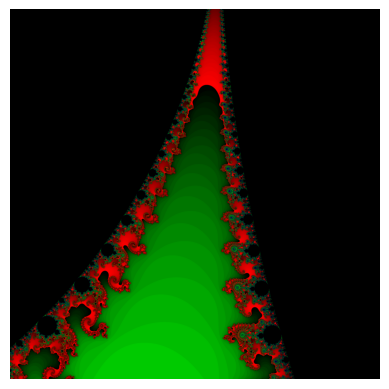

In [ ]:
import cv2
import matplotlib.pyplot as plt
img = cv2.imread("mandelbrot.ppm")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')

##7.2. K-Means Clustering
We will implement the [k-means algorithm](https://en.wikipedia.org/wiki/K-means_clustering) for clustering data.

We will need some notation to set the stage for the geometric clustering of data points. First let's assume we have $N$ data points and that data point with index $i$ has $d$-dimensional coordinates $(x_i^0,x_i^1, \ldots, x_i^{d-1})$.

Our goal is to assign an integer label $c_i$ to data point $i$ for $i=0,\ldots, N-1$. This will assert an affinity between the data point and cluster group. All data points associated with the same cluster will have the same label, i.e. if $c_1 = c_{10}$ then data points $1$ and $10$ will be considered to be in the same group. Moreover, the integer values of $c_i$ must be in the range $[0, K).


We will need to be able to compute the centroid of data points in each cluster. To do this you can compute moments of the data relative to the cluster groups as follows. The zero moment, sometimes known as the cardinality of the groups is computable for cluster $k$ with the following formula cluster defined by
\begin{align*}
C_k := \sum_{i=0}^{i=N-1} \delta_{k,c_i},
\end{align*}

which you will recognize after a moment's reflection as the number of data points assigned to the cluster with label $k$ (since the quantity in the summation is one if the point is in cluster $k$ or zero otherwise). Here $\delta_{a,b}$ denotes the Kronecker delta given by
\begin{align*}
\delta_{a,b} = \left\{ \begin{array}{l} 1\;\mbox{if}\;a=b, \\
0\;\mbox{otherwise}.
\end{array}\right.
\end{align*}


The first moment, sometimes known as the centroid of  cluster $k$ is computed by
\begin{align*}
    \hat{x}^j_k:= \frac{1}{C_k} \sum_{i=0}^{i=N-1} x^j_i\delta_{c_i,k}, \quad \text{where} \quad j = 0,1,\ldots, d-1
\end{align*}
and you can think of this as the geometric center of the data points that have the label $k$.


The k-means clustering problem seeks to group data points into $K$ clusters. That means we must choose an integer numerical labeling of the nodes (i.e. choose $c_i\in 0, \ldots, K-1$ for $i \in 0, \ldots, N-1$) that minimizes the total sum of squares of the distances between the data points and the centroids of their assigned cluster given by this formula
\begin{align*}
dx:=\sum_{j=0}^{j=d-1} \left(\sum_{i=0}^{i=N-1} (x^j_i - \hat{x}^j_{c_i})^2\right)
\end{align*}

In words: you need to assign the data points to cluster in a way that collectively minimizes the variance of the data points from their assigned cluster centroids.

<!-- Here is the pseudo-code for the k-means algorithm of Lloyd (Lloyd, 1982):
\begin{algorithm}[htbp!]
\caption{Lloyd's clustering algorithm}
\label{lloyd.alg}
\vspace{4pt}
\KwInput{$N,K\in\mathbb{N}, j \in \mathbb{R}^d$}
\KwInput{$x\in \mathbb{R}^{N\times d}$}
\KwInput{$\mbox{tol}\in \mathbb{R}$}
\KwInputOutput{$c\in \mathbb{N}^N$}
\KwRequire{$0\leq c_i < K$}
\algrule
 \While{centroid change exceeds TOL}{
   Algorithm 1: assign each datapoint to cluster with nearest centroid \;
   Algorithm 2: recompute centroids of clusters \;
   Compute maximum change of centroids \;
 }
\end{algorithm} -->

**CODE is Coming Soon**

In [ ]:
%%writefile kmeans.c
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include<string.h>

/* ************************************************************************* */
int Nd, Nc, Np;
double TOL;

#define BUFSIZE 512
#define MAX(x, y) (((x) > (y)) ? (x) : (y))
#define MIN(x, y) (((x) < (y)) ? (x) : (y))

// Define maximum number of iterations
#define MAX_ITER 10000

/* ************************************************************************** */
double readInputFile(char *fileName, char* tag){
  FILE *fp = fopen(fileName, "r");
  // Error Check
  if (fp == NULL) {
    printf("Error opening the input file\n");
  }

  int sk = 0; double result;
  char buffer[BUFSIZE], fileTag[BUFSIZE];

  while(fgets(buffer, BUFSIZE, fp) != NULL){
    sscanf(buffer, "%s", fileTag);
    if(strstr(fileTag, tag)){
      fgets(buffer, BUFSIZE, fp);
      sscanf(buffer, "%lf", &result);
      sk++;
      return result;
    }
  }

  if(sk==0){
    printf("ERROR! Could not find the tag: [%s] in the file [%s]\n", tag, fileName);
    exit(EXIT_FAILURE);
  }
}

/* ************************************************************************** */
void readDataFile(char *fileName, double *data){
  FILE *fp = fopen(fileName, "r");
  if (fp == NULL) {
    printf("Error opening the input file\n");
  }

  int sk = 0;
  char buffer[BUFSIZE], fileTag[BUFSIZE];

  int shift = Nd;
  while(fgets(buffer, BUFSIZE, fp) != NULL){
      if(Nd==2)
        sscanf(buffer, "%lf %lf", &data[sk*shift + 0], &data[sk*shift+1]);
      if(Nd==3)
        sscanf(buffer, "%lf %lf %lf", &data[sk*shift + 0], &data[sk*shift+1], &data[sk*shift+2]);
      if(Nd==4)
        sscanf(buffer, "%lf %lf %lf %lf", &data[sk*shift+0],&data[sk*shift+1], &data[sk*shift+2], &data[sk*shift+3]);
      sk++;
  }
}

/* ************************************************************************** */
void writeDataToFile(char *fileName, double *data, int *Ci){
  FILE *fp = fopen(fileName, "w");
  if (fp == NULL) {
    printf("Error opening the output file\n");
  }

  for(int p=0; p<Np; p++){
    fprintf(fp, "%d %d ", p, Ci[p]);
    for(int dim=0; dim<Nd; dim++){
      fprintf(fp, "%.4f ", data[p*Nd + dim]);
    }
    fprintf(fp, "\n");
  }
  fclose(fp);
}

/* ************************************************************************** */
void writeCentroidToFile(char *fileName, double *Cm){
  FILE *fp = fopen(fileName, "w");
  if (fp == NULL) {
    printf("Error opening the output file\n");
  }

  for(int n=0; n<Nc; n++){
    for(int dim=0; dim<Nd; dim++){
      fprintf(fp, "%.4f ", Cm[n*Nd + dim]);
    }
    fprintf(fp, "\n");
  }
  fclose(fp);
}

/*************************************************************************** */
// Function to calculate Euclidean distance between two points
double distance(double *a, double *b) {
  double sum = 0.0;
  for(int dim=0; dim < Nd; dim++){
    sum += pow((a[dim] - b[dim]), 2);
  }
  return sqrt(sum);
}


/* ************************************************************************* */
// Function to assign each point to the nearest centroid
void assignPoints(double *data, int *Ci, int *Ck, double *Cm) {

    // Reset the number of points in the cluster
    for(int n = 0; n < Nc; n++) {
        Ck[n] = 0;
    }

    // Go over each point
    for (int p = 0; p < Np; p++) {
        double min_distance = INFINITY;
        int cluster_index   = 0;

        for (int n = 0; n < Nc; n++){
            double d = distance(&data[p*Nd], &Cm[n*Nd]);
            if (d < min_distance) {
                min_distance  = d;
                cluster_index = n;
            }
        }

        Ck[cluster_index] +=1;
        Ci[p]              = cluster_index;
    }
}

/* ************************************************************************* */
// Function to update centroids based on the mean of assigned points
double updateCentroids(double *data, int *Ci, int *Ck, double *Cm) {

  double *CmCopy = (double *)malloc(Nc*Nd*sizeof(double));
  // memcpy(CmCopy, Cm, Nc*Nd*sizeof(double));

 //
  for(int n = 0; n < Nc; n++) {
    for(int dim = 0; dim<Nd; dim++){
      CmCopy[n*Nd + dim] =  Cm[n*Nd + dim];
      Cm[n*Nd + dim] = 0.0;
    }
  }

  for(int p=0; p<Np; p++){
    // Get cluster of the point
    int cluster_index = Ci[p];

    for(int dim = 0; dim<Nd; dim++){
      Cm[cluster_index*Nd + dim] += data[p*Nd + dim];
    }
  }

   double err = 1.E-12;
   for (int n = 0; n < Nc; n++){
     for(int dim = 0; dim<Nd; dim++){
      Cm[n*Nd + dim] = Cm[n*Nd + dim]/Ck[n];
      err = MAX(err, fabs(Cm[n*Nd + dim] - CmCopy[n*Nd + dim]));
     }
   }

   free(CmCopy);
 return err;



}

/* ************************************************************************* */
// Function to perform k-means clustering
void kMeans(double *data, int *Ci, int *Ck, double *Cm) {

  // Initialize clusters randomly
  for (int n = 0; n < Nc; n++) {
    int ids = rand() % Np;
    for(int dim = 0; dim<Nd; dim++){
      Cm[n*Nd + dim] = data[ids*Nd+ dim];
    }
    Ck[n]   = 0;
    Ci[ids] = n;
  }

  double err = INFINITY;

  int sk = 0;
  while(err>TOL) {
    assignPoints(data, Ci, Ck, Cm);
    err = updateCentroids(data, Ci, Ck, Cm);
    printf("\r Iteration %d %.12e\n", sk, err);sk++;
    fflush(stdout);
  }
  printf("\n");
}

/* ************************************************************************* */

int main ( int argc, char *argv[] ){
    if(argc!=3){
      printf("Usage: ./kmeans input.dat data.dat\n");
      return -1;
    }

    // Read Number of Data Points
    Np = (int) readInputFile(argv[1], "NUMBER_OF_POINTS");
    // Read Number of clusters
    Nc = (int) readInputFile(argv[1], "NUMBER_OF_CLUSTERS");
    // Read Dimension of Data
    Nd = (int) readInputFile(argv[1], "DATA_DIMENSION");
    // Read Tolerance
    TOL = readInputFile(argv[1], "TOLERANCE");

    // Allocate data [x_i, y_i, z_i, ...]
    double *data = (double*) malloc(Np*Nd*sizeof(double));
    // Cluster id mapping every point to cluster
    int      *Ci = (int *) calloc(Np, sizeof(int));
    // Number of data points in every cluster
    int      *Ck = (int *) calloc(Nc, sizeof(int));
    // Centroid of every clusters
    double   *Cm = (double*) calloc(Nc*Nd, sizeof(double));

    // Fill point data from file
    readDataFile(argv[2], data);

    // Perform k-means clustering
    kMeans(data, Ci, Ck, Cm);

    // Report Results
    for(int n=0; n<Nc; n++){
      int Npoints =Ck[n];
      printf("(%d of %d) points are in the cluster %d with centroid( ", Npoints, Np, n);
       for(int dim = 0; dim<Nd; dim++){
               printf("%f ", Cm[n*Nd + dim]);
        }
      printf(") \n");

    }

    writeDataToFile("output.dat",    data, Ci);
    writeCentroidToFile("centroids.dat", Cm);


    free(data);
    free(Ci);
    free(Ck);
    free(Cm);

    return 0;
}

Writing kmeans.c


In [ ]:
!gcc kmeans.c -o kmns -lm
!./kmns ./kmeans/input.dat ./kmeans/isolation_N9000.dat

 Iteration 0 4.065002782827e-01
 Iteration 1 1.507416591471e-01
 Iteration 2 1.449893456290e-01
 Iteration 3 1.416229708567e-01
 Iteration 4 7.498946085901e-02
 Iteration 5 2.144576204765e-02
 Iteration 6 1.463026409473e-02
 Iteration 7 1.397327308582e-02
 Iteration 8 1.147538631494e-02
 Iteration 9 1.088223669923e-02
 Iteration 10 1.129816078326e-02
 Iteration 11 8.186704338104e-03
 Iteration 12 5.462078229669e-03
 Iteration 13 4.268613770131e-03
 Iteration 14 4.758520799589e-03
 Iteration 15 3.724395397814e-03
 Iteration 16 4.618064588649e-03
 Iteration 17 3.616050262937e-03
 Iteration 18 5.513988935581e-03
 Iteration 19 5.300536968154e-03
 Iteration 20 4.696969489204e-03
 Iteration 21 6.473031148180e-03
 Iteration 22 5.979012627411e-03
 Iteration 23 5.231869945747e-03
 Iteration 24 4.369529706401e-03
 Iteration 25 3.866233565383e-03
 Iteration 26 3.213620606555e-03
 Iteration 27 3.556264345189e-03
 Iteration 28 3.332165912385e-03
 Iteration 29 3.366762652846e-03
 Iteration 30 4.3147